##**Packages to be installed during runtime**

In [ ]:
pip install pyspark

     |████████████████████████████████| 212.3MB 71kB/s 
     |████████████████████████████████| 204kB 17.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=1ee8d30cff703507805117d0699af7855d81ef14f21abff12431dd9199d9ccee
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


## **Importing Necessary Libraries**

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF,RegexTokenizer,StopWordsRemover
from pyspark.ml.classification import NaiveBayes,LinearSVC,LogisticRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import operator

## **File Reading**

In [ ]:
sc = SparkContext();
spark = SparkSession.builder.appName('Sentiment Analysis').getOrCreate();

In [ ]:
train_data = open("train.ft.txt", "r")
test_data=open("test.ft.txt", "r")

In [ ]:
train_data_lines=train_data.readlines()
test_data_lines=test_data.readlines()

In [ ]:
len(train_data_lines)

46232

In [ ]:
len(test_data_lines)

123803

In [ ]:
tr_label=[0 if i.split(' ')[0]=='__label__1' else 1 for i in train_data_lines]
te_label=[0 if i.split(' ')[0]=='__label__1' else 1 for i in test_data_lines]

In [ ]:
tr_sentences=[i.split(' ',1)[1][:-1] for i in train_data_lines]
te_sentences=[i.split(' ',1)[1][:-1] for i in test_data_lines]

## **Creating Necessary Functions** 

In [ ]:
def model_evaluation(model_name,training,testing):
  clf=model_name(labelCol='Labels',featuresCol='Features')
  model=clf.fit(training)

  pred=model.transform(testing).select("Labels","Important_Words","prediction")
  corr_pred=pred.filter(pred['prediction']==pred['Labels'])
  acc=(corr_pred.count()/pred.count())*100
  return(acc)

## **Train Dataset**

In [ ]:
train_dict={'Labels':[],'Sentences':[]}
for i in range(len(tr_label)):
  train_dict['Labels'].append(tr_label[i])
  train_dict['Sentences'].append(tr_sentences[i])

In [ ]:
df=pd.DataFrame(data=train_dict,columns=["Labels","Sentences"])
df.head()
df.shape

(46232, 2)

In [ ]:
test_dict={'Labels':[],'Sentences':[]}
for i in range(len(te_label)):
  test_dict['Labels'].append(te_label[i])
  test_dict['Sentences'].append(te_sentences[i])

In [ ]:
dft=pd.DataFrame(data=test_dict,columns=["Labels","Sentences"])
dft.head()
dft.shape

(123803, 2)

## **Data Pre-Processing and Visualization**

1    50.95
0    49.05
Name: Labels, dtype: float64


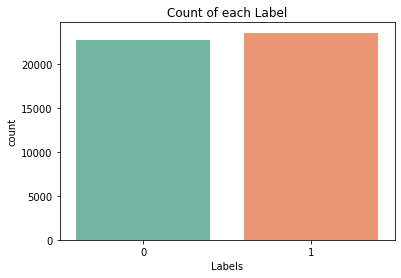

In [ ]:
#Count Plot
sns.countplot(x='Labels',data=df,palette="Set2")
x=df['Labels'].value_counts()
print(round((x/len(df['Labels']))*100,2))
plt.title('Count of each Label')
plt.show()

In [ ]:
#Creating a Spark dataframe from train data
train_df=spark.read.csv('train.csv',inferSchema=True,header=True)
train_df.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Labels|Sentences                                                                                                                                                    

In [ ]:
#Tokenization
tokenizer= RegexTokenizer(inputCol="Sentences",outputCol="Words",pattern="\\W")
tok_train=tokenizer.transform(train_df)
tok_train.show()

+------+--------------------+--------------------+
|Labels|           Sentences|               Words|
+------+--------------------+--------------------+
|     1|Stuning even for ...|[stuning, even, f...|
|     1|The best soundtra...|[the, best, sound...|
|     1|"Amazing!: This s...|[amazing, this, s...|
|     1|Excellent Soundtr...|[excellent, sound...|
|     1|Remember, Pull Yo...|[remember, pull, ...|
|     1|an absolute maste...|[an, absolute, ma...|
|     0|"Buyer beware: Th...|[buyer, beware, t...|
|     1|Glorious story: I...|[glorious, story,...|
|     1|A FIVE STAR BOOK:...|[a, five, star, b...|
|     1|Whispers of the W...|[whispers, of, th...|
|     0|The Worst!: A com...|[the, worst, a, c...|
|     1|Great book: This ...|[great, book, thi...|
|     1|Great Read: I tho...|[great, read, i, ...|
|     0|Oh please: I gues...|[oh, please, i, g...|
|     0|"Awful beyond bel...|[awful, beyond, b...|
|     0|Don't try to fool...|[don, t, try, to,...|
|     1|"A romantic zen b...|[a

In [ ]:
#Removing stop-words
stopwords= ["http","https","actually",".com",".org"] 
stopwords.extend(StopWordsRemover().getStopWords())
stopwords = list(set(stopwords))

stop_words_remover=StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="Important_Words",stopWords=stopwords)
stop_train=stop_words_remover.transform(tok_train)
stop_train.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#Creating a word cloud
words=stop_train.select('Important_Words').collect()
w=""
for i in range(len(words)):
    w+=str(words[i][0])
w=w.replace("'","")

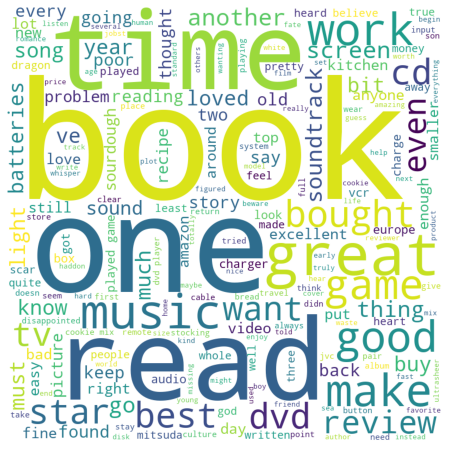

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(w[:20000])

plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#Performing Hashing Term Frequency
hashing_TF=HashingTF(inputCol=stop_words_remover.getOutputCol(),outputCol="Features")
hash_train=hashing_TF.transform(stop_train).select('Labels','Important_Words','Features')
hash_train.show()

+------+--------------------+--------------------+
|Labels|     Important_Words|            Features|
+------+--------------------+--------------------+
|     1|[stuning, even, n...|(262144,[9129,435...|
|     1|[best, soundtrack...|(262144,[21823,23...|
|     1|[amazing, soundtr...|(262144,[378,1378...|
|     1|[excellent, sound...|(262144,[2701,120...|
|     1|[remember, pull, ...|(262144,[378,6946...|
|     1|[absolute, master...|(262144,[378,6946...|
|     0|[buyer, beware, s...|(262144,[6346,218...|
|     1|[glorious, story,...|(262144,[4235,804...|
|     1|[five, star, book...|(262144,[6261,127...|
|     1|[whispers, wicked...|(262144,[3524,912...|
|     0|[worst, complete,...|(262144,[15960,48...|
|     1|[great, book, gre...|(262144,[3524,161...|
|     1|[great, read, tho...|(262144,[2325,535...|
|     0|[oh, please, gues...|(262144,[6261,181...|
|     0|[awful, beyond, b...|(262144,[4900,978...|
|     0|[try, fool, us, f...|(262144,[43224,61...|
|     1|[romantic, zen, b...|(2

In [ ]:
#Common words with labels 0 and 1 respectively
lab_word0={}
lab_word1={}
labels=[]
lab=hash_train.select('Labels').collect()
for i in range(len(lab)):
  labels.append(lab[i][0])

In [ ]:
for i in range(len(lab)):
  if(labels[i]==0):
    for j in range(len(words[i][0])):
      if(words[i][0][j] not in lab_word0.keys()):
        lab_word0[words[i][0][j]]=1
      else:
        lab_word0[words[i][0][j]]+=1
  else:
    for j in range(len(words[i][0])):
      if(words[i][0][j] not in lab_word1.keys()):
        lab_word1[words[i][0][j]]=1
      else:
        lab_word1[words[i][0][j]]+=1

lab_word0 = dict(sorted(lab_word0.items(), key=lambda item: item[1],reverse=True))
lab_word1 = dict(sorted(lab_word1.items(), key=operator.itemgetter(1),reverse=True))

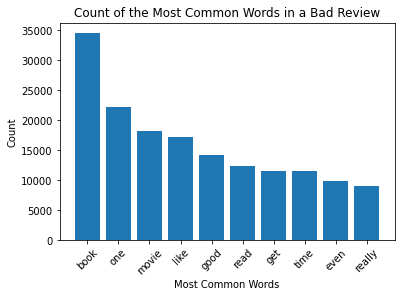

In [ ]:
keys=list(lab_word0.keys())[:10]
values=list(lab_word0.values())[:10]
plt.bar(keys,values)
plt.xticks(rotation=45)
plt.xlabel('Most Common Words')
plt.ylabel('Count')
plt.title('Count of the Most Common Words in a Bad Review')
plt.show()

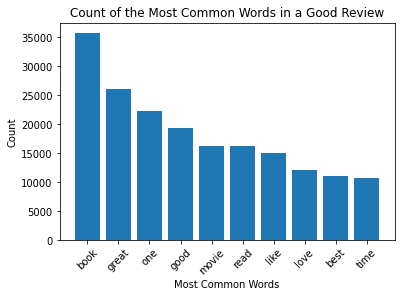

In [ ]:
keys=list(lab_word1.keys())[:10]
values=list(lab_word1.values())[:10]
plt.bar(keys,values)
plt.xticks(rotation=45)
plt.xlabel('Most Common Words')
plt.ylabel('Count')
plt.title('Count of the Most Common Words in a Good Review')
plt.show()

**Observations and Inferences** 


1. 'Book' is the most common word as shown by the word cloud   
2. The word 'book' is present in both the graphs given above (Good and Bad Review). This indicates that the overall count of popular words is not a good visualization with this dataset as the reviews are wordy



## **Test Dataset**

In [ ]:
test_df=spark.read.csv('test.csv',inferSchema=True,header=True)

tokenizer_test=RegexTokenizer(inputCol="Sentences",outputCol="Words",pattern="\\W")
tok_test=tokenizer_test.transform(test_df)

stop_words_r=StopWordsRemover(inputCol=tokenizer_test.getOutputCol(),outputCol="Important_Words")
stop_test=stop_words_r.transform(tok_test)

hash_test=HashingTF(inputCol=stop_words_r.getOutputCol(),outputCol="Features").transform(stop_test)

## **Model evaluations** 

In [ ]:
training= hash_train
testing= hash_test
svm=round(model_evaluation(LinearSVC,training,testing),2)
nb=round(model_evaluation(NaiveBayes,training,testing),2)
lr=round(model_evaluation(LogisticRegression,training,testing),2)
print("The accuracy of SVM is =",svm,"%")
print("The accuracy of Naive Bayes is =",nb,"%")
print("The accuracy of Logistic Regression is =",lr,"%")

The accuracy of SVM is = 84.71 %
The accuracy of Naive Bayes is = 83.85 %
The accuracy of Logistic Regression is = 75.4 %


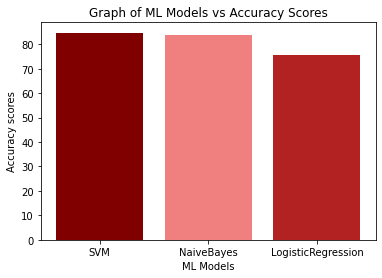

In [ ]:
x= ["SVM","NaiveBayes","LogisticRegression"]
y=[svm,nb,lr]
color=['maroon','lightcoral','firebrick']
plt.bar(x,y, color = color)
plt.xlabel('ML Models')
plt.ylabel('Accuracy scores')
plt.title("Graph of ML Models vs Accuracy Scores")
plt.show()

## **Thank You!**